In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport inference
%aimport graph
%aimport hyper
%aimport seq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from scipy.io import loadmat, savemat
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis
from sklearn.decomposition.factor_analysis import FactorAnalysis

import simulation, util, inference, graph, hyper, seq
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [8]:
sns.set_style("white")
PLDScolor = sns.xkcd_rgb["pale red"]
GPFAcolor =  sns.xkcd_rgb["medium green"]
vLGPcolor = sns.xkcd_rgb["denim blue"]

samplepath = os.path.expanduser("~/data/sample")
outputpath = os.path.expanduser("~/data/output")

# PLDS Sample

In [9]:
# dimensions
nsample = 5
ntrial = 10
ntime = 1000
nchannel = 50
nlatent = 3

In [78]:
fPLDSSample = ['{}/PLDS_{}'.format(samplepath, i + 1) for i in range(nsample)]
PLDSSample = []
for i, fname in enumerate(fPLDSSample):
    mat = loadmat(fname, squeeze_me=True)
    PLDSSample.append(mat)

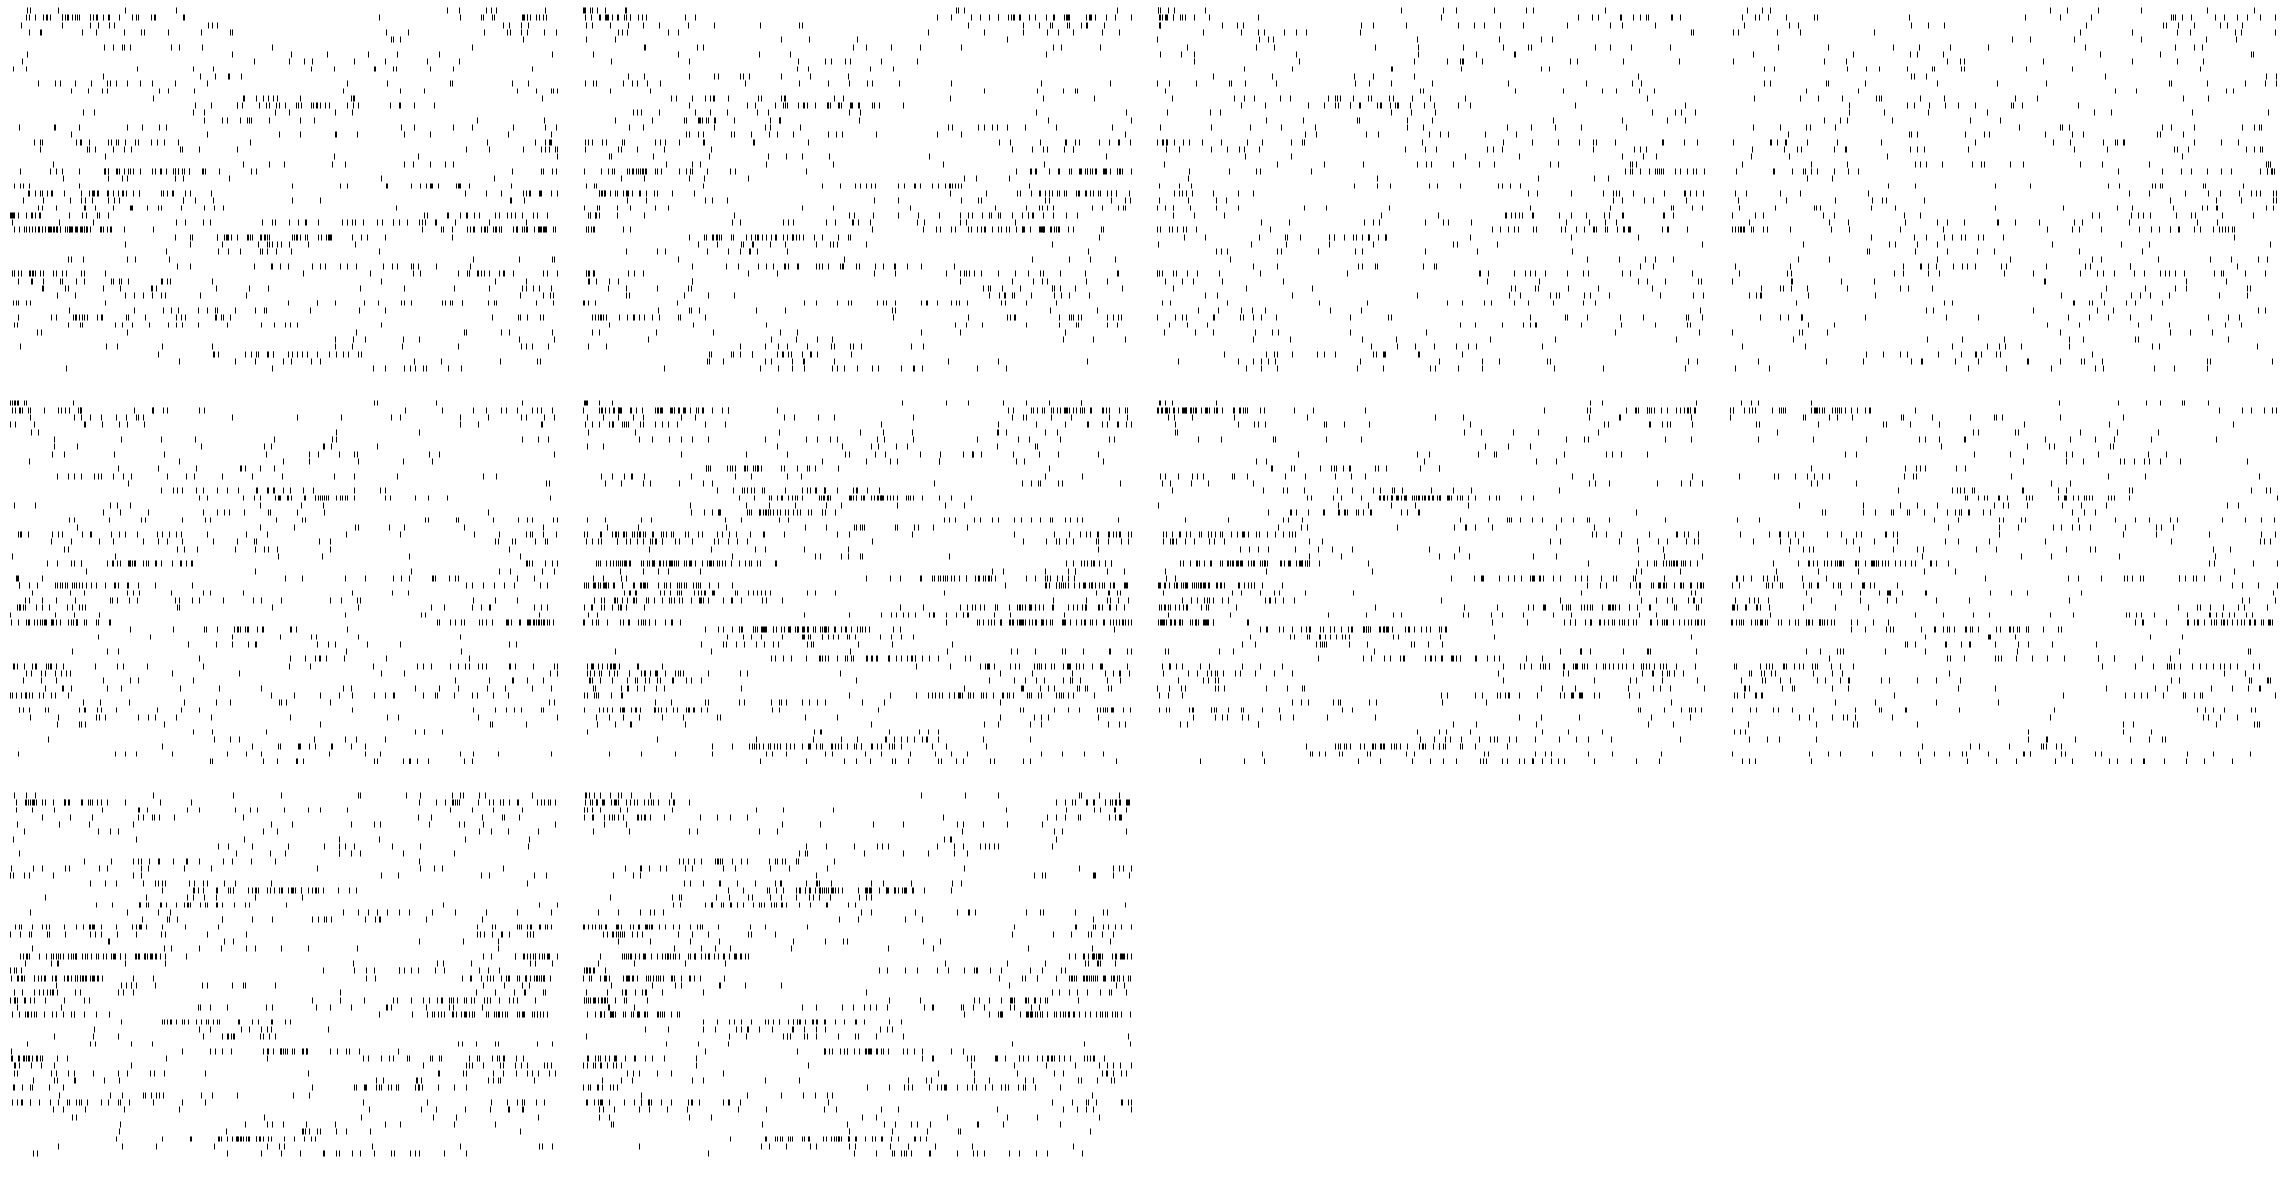

In [79]:
graph.rasterplot(PLDSSample[1]['y'])

In [80]:
for i in range(nsample):
    print('Sample {}'.format(i + 1))
    print('\t Mean spike per neuron\n\t', PLDSSample[i]['y'].mean(axis=(0, 1)) * ntime)
    print('\t Mean spike\n\t', PLDSSample[i]['y'].mean() * ntime)

Sample 1
	 Mean spike per neuron
	 [ 11.7  40.9  16.2  16.3   6.3  12.    8.9  11.1   8.6  10.6  17.7   9.3
  15.8  27.2  10.3  17.2  16.2  12.6  27.2  18.1   8.7  10.8  43.4   7.7
  18.9  41.6  16.6  19.7  25.9  16.   58.2  26.5  10.4  11.9  10.7  19.8
  32.8  14.9  15.4  15.6  22.9   8.9  24.1  14.2   8.6   6.8  11.2  22.6
  14.7  12.6]
	 Mean spike
	 17.726
Sample 2
	 Mean spike per neuron
	 [ 13.   49.   17.3  18.    7.9  12.1   7.1  11.7   8.9  12.6  16.7   9.7
  17.8  35.9  10.2  20.1  17.9  12.4  35.   22.1   8.9  10.1  53.3   8.3
  24.1  51.3  16.3  23.   35.4  18.6  67.9  33.6  12.8  12.7   9.8  23.3
  39.6  18.9  18.4  17.7  28.1  11.1  30.2  14.5   9.6   8.3  12.1  25.6
  15.7  16.8]
	 Mean spike
	 20.628
Sample 3
	 Mean spike per neuron
	 [ 12.2  44.8  15.6  18.7   9.1  12.7   6.8  10.6   8.2  13.7  14.2  10.9
  17.4  38.6  10.   21.5  17.9  12.8  34.1  21.7  10.1   9.8  55.7  10.2
  22.7  56.2  17.6  23.8  34.1  17.4  65.6  33.1  13.3  13.4  12.5  23.6
  39.   19.1  17.8  

In [81]:
for i, sample in enumerate(PLDSSample):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.full(nlatent, fill_value=1e-5)
    result = inference.fit(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
                                   alpha=sample['alpha'], beta=sample['beta'], lag=0, rank=100, 
                                   niter=100, tol=1e-5, verbose=False, hyper=True)
    savemat('{}/PLDS_{}_vLGP'.format(outputpath, i + 1), result)
print('Done.')

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Done.


In [ ]:
# cv
for i, sample in enumerate(PLDSSample):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = PLDS_vLGP[i]['omega']
    result = inference.cv(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, lag=0, rank=100, 
                                   niter=100, tol=1e-5, hyper=False)
    savemat('{}/PLDS_{}_vLGP_pred'.format(outputpath, i + 1), result)
print('Done.')

In [82]:
fvLGP = [os.path.join(outputpath, 'PLDS_{}_vLGP'.format(i+1)) for i in range(nsample) ]
PLDS_vLGP = [loadmat(fname, squeeze_me=True) for fname in fvLGP]

In [83]:
idx = np.array([r['LatentAngle'][-1] for r in PLDS_vLGP]).argmin()
best_PLDS_vLGP = PLDS_vLGP[idx]
print('Best: ', idx)

Best:  1


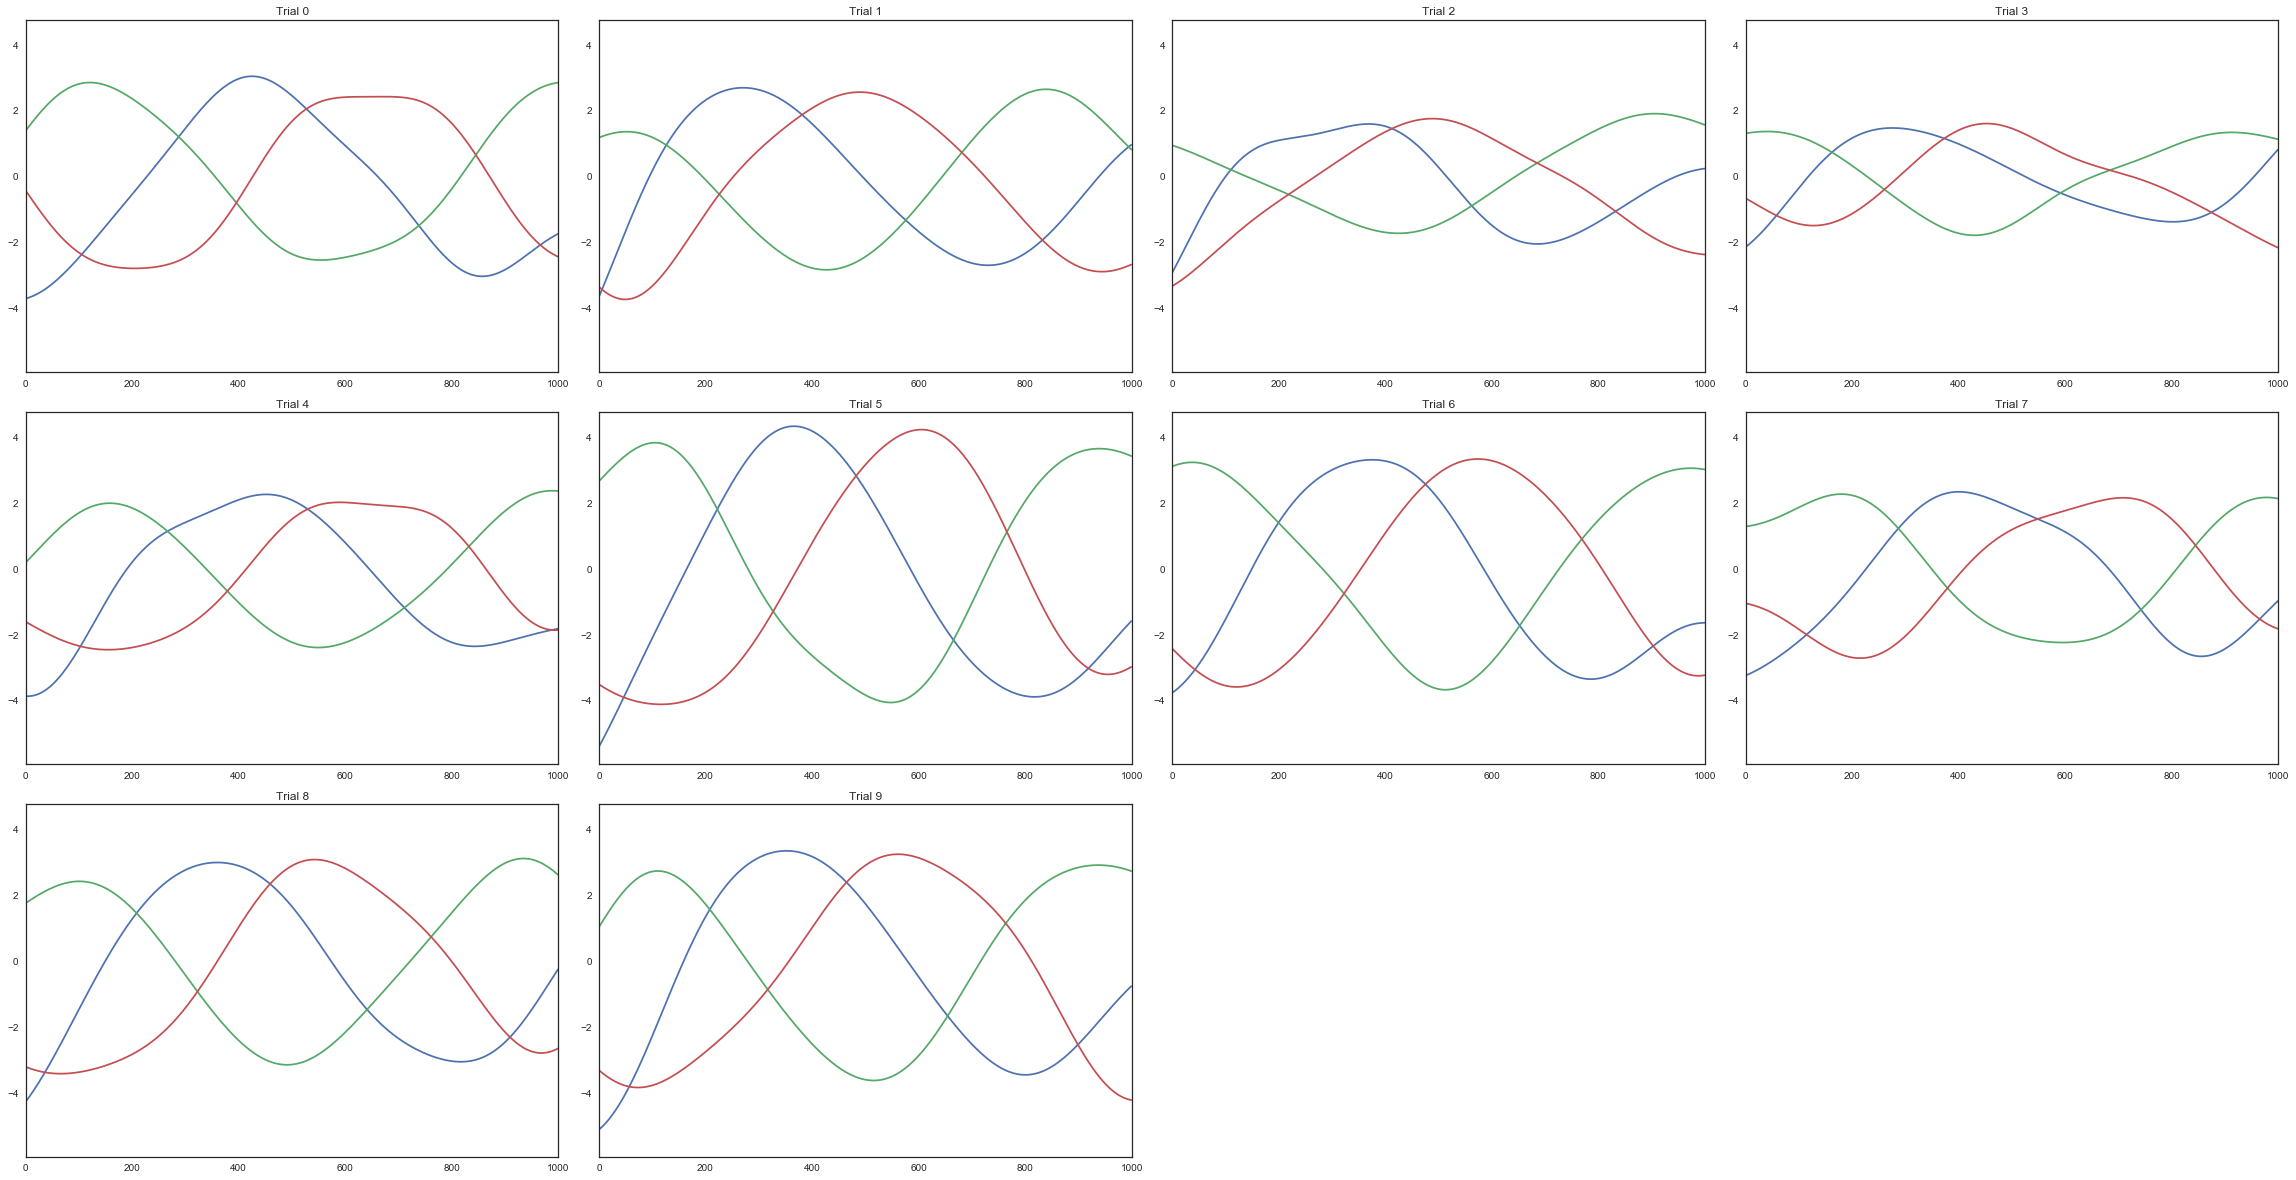

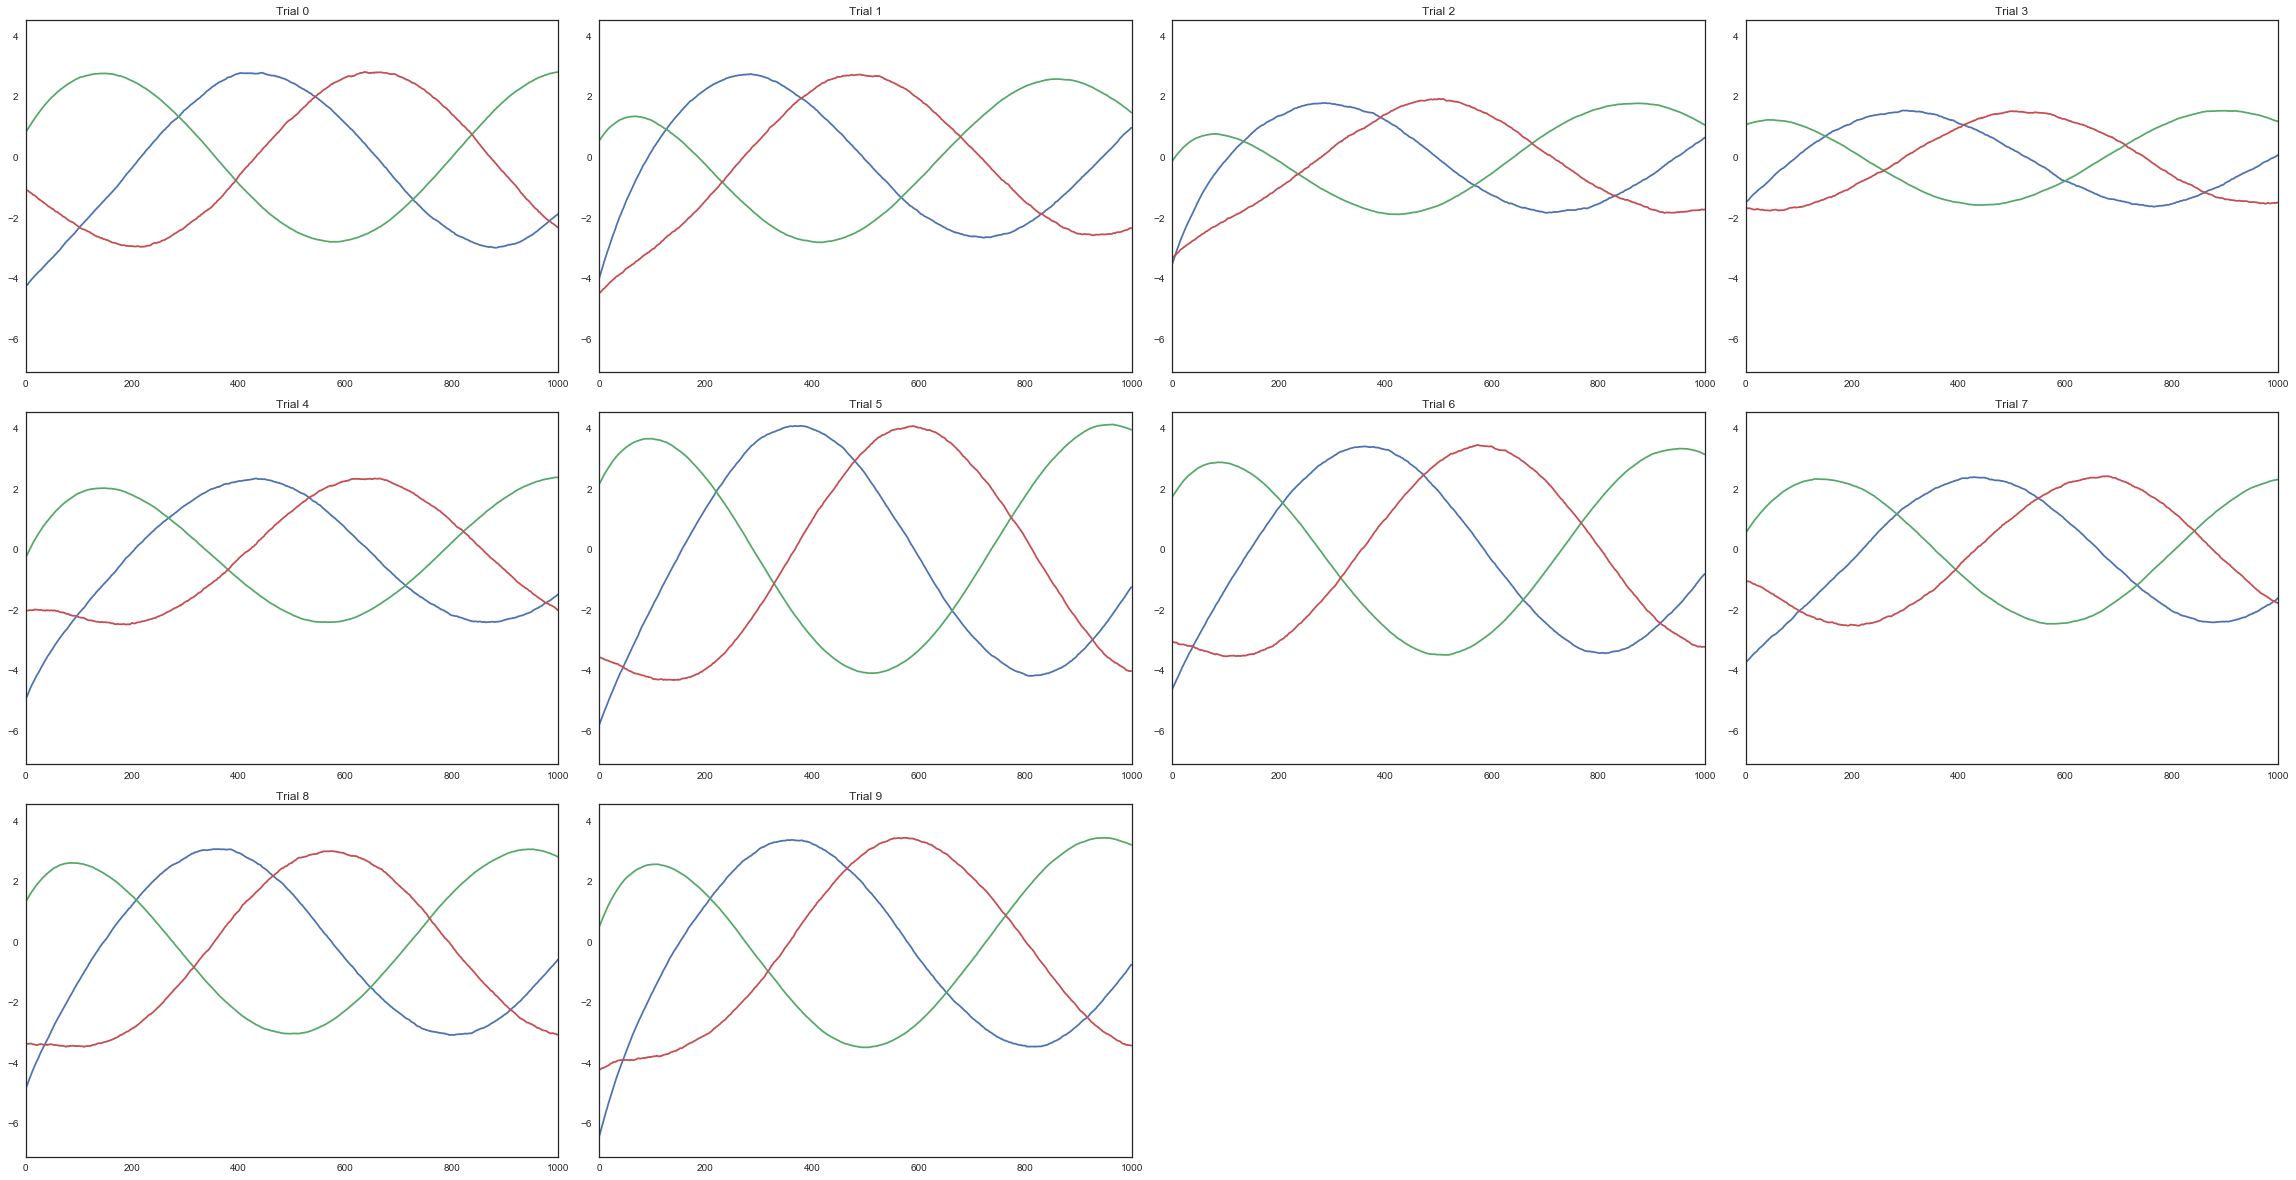

In [84]:
rotated = np.empty_like(best_PLDS_vLGP['mu'])
for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(best_PLDS_vLGP['mu'][i, :]), best_PLDS_vLGP['x'][i, :])

graph.dynplot(rotated)
graph.dynplot(best_PLDS_vLGP['x'])

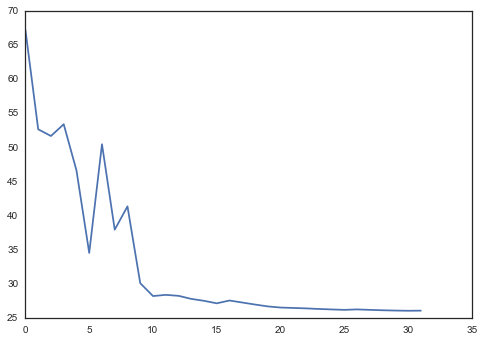

In [85]:
plt.plot(rad2deg(best_PLDS_vLGP['LatentAngle']));

In [87]:
rad2deg(np.array([r['LatentAngle'][-1] for r in PLDS_vLGP]))

array([ 30.12387103,  26.04771579,  40.35794229,  54.73642914,  57.41371792])

In [120]:
fvLGP = [os.path.join(outputpath, 'PLDS_{}_GPFA'.format(i+1)) for i in range(nsample) ]
PLDS_GPFA = [loadmat(fname, squeeze_me=True) for fname in fvLGP]

In [121]:
idx = np.array([r['latentAngle'][-1] for r in PLDS_GPFA]).argmin()
best_PLDS_GPFA = PLDS_GPFA[idx]
print('Best: ', idx)

Best:  2


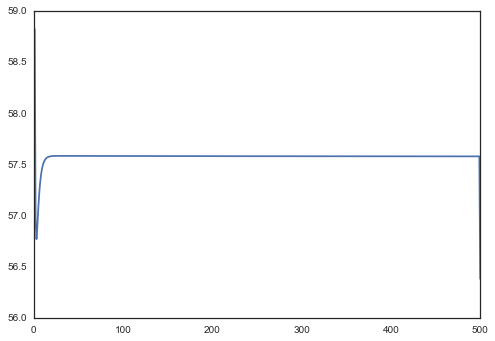

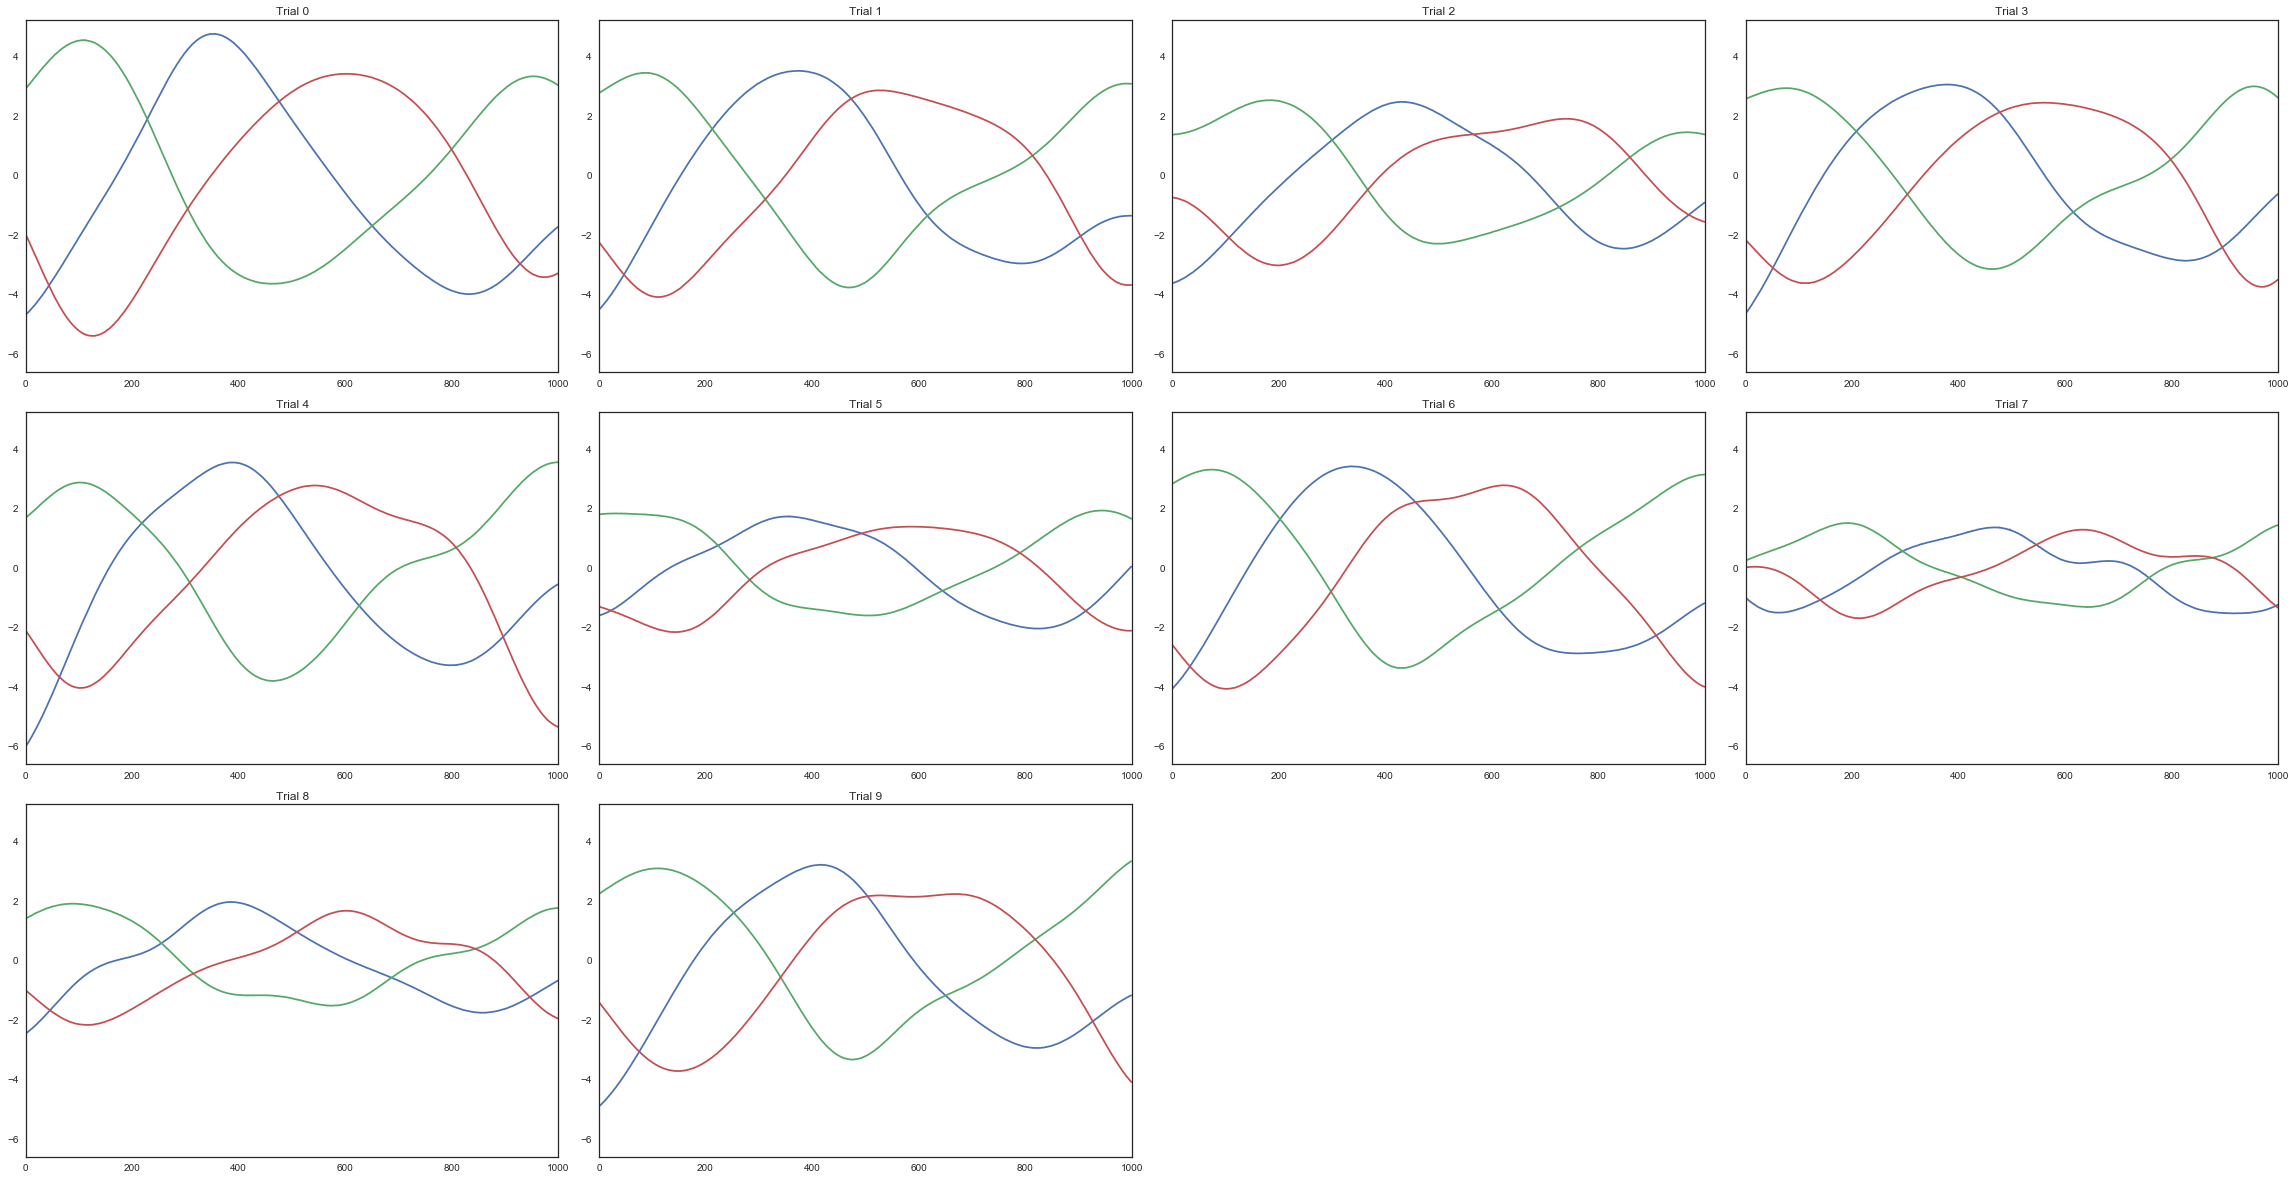

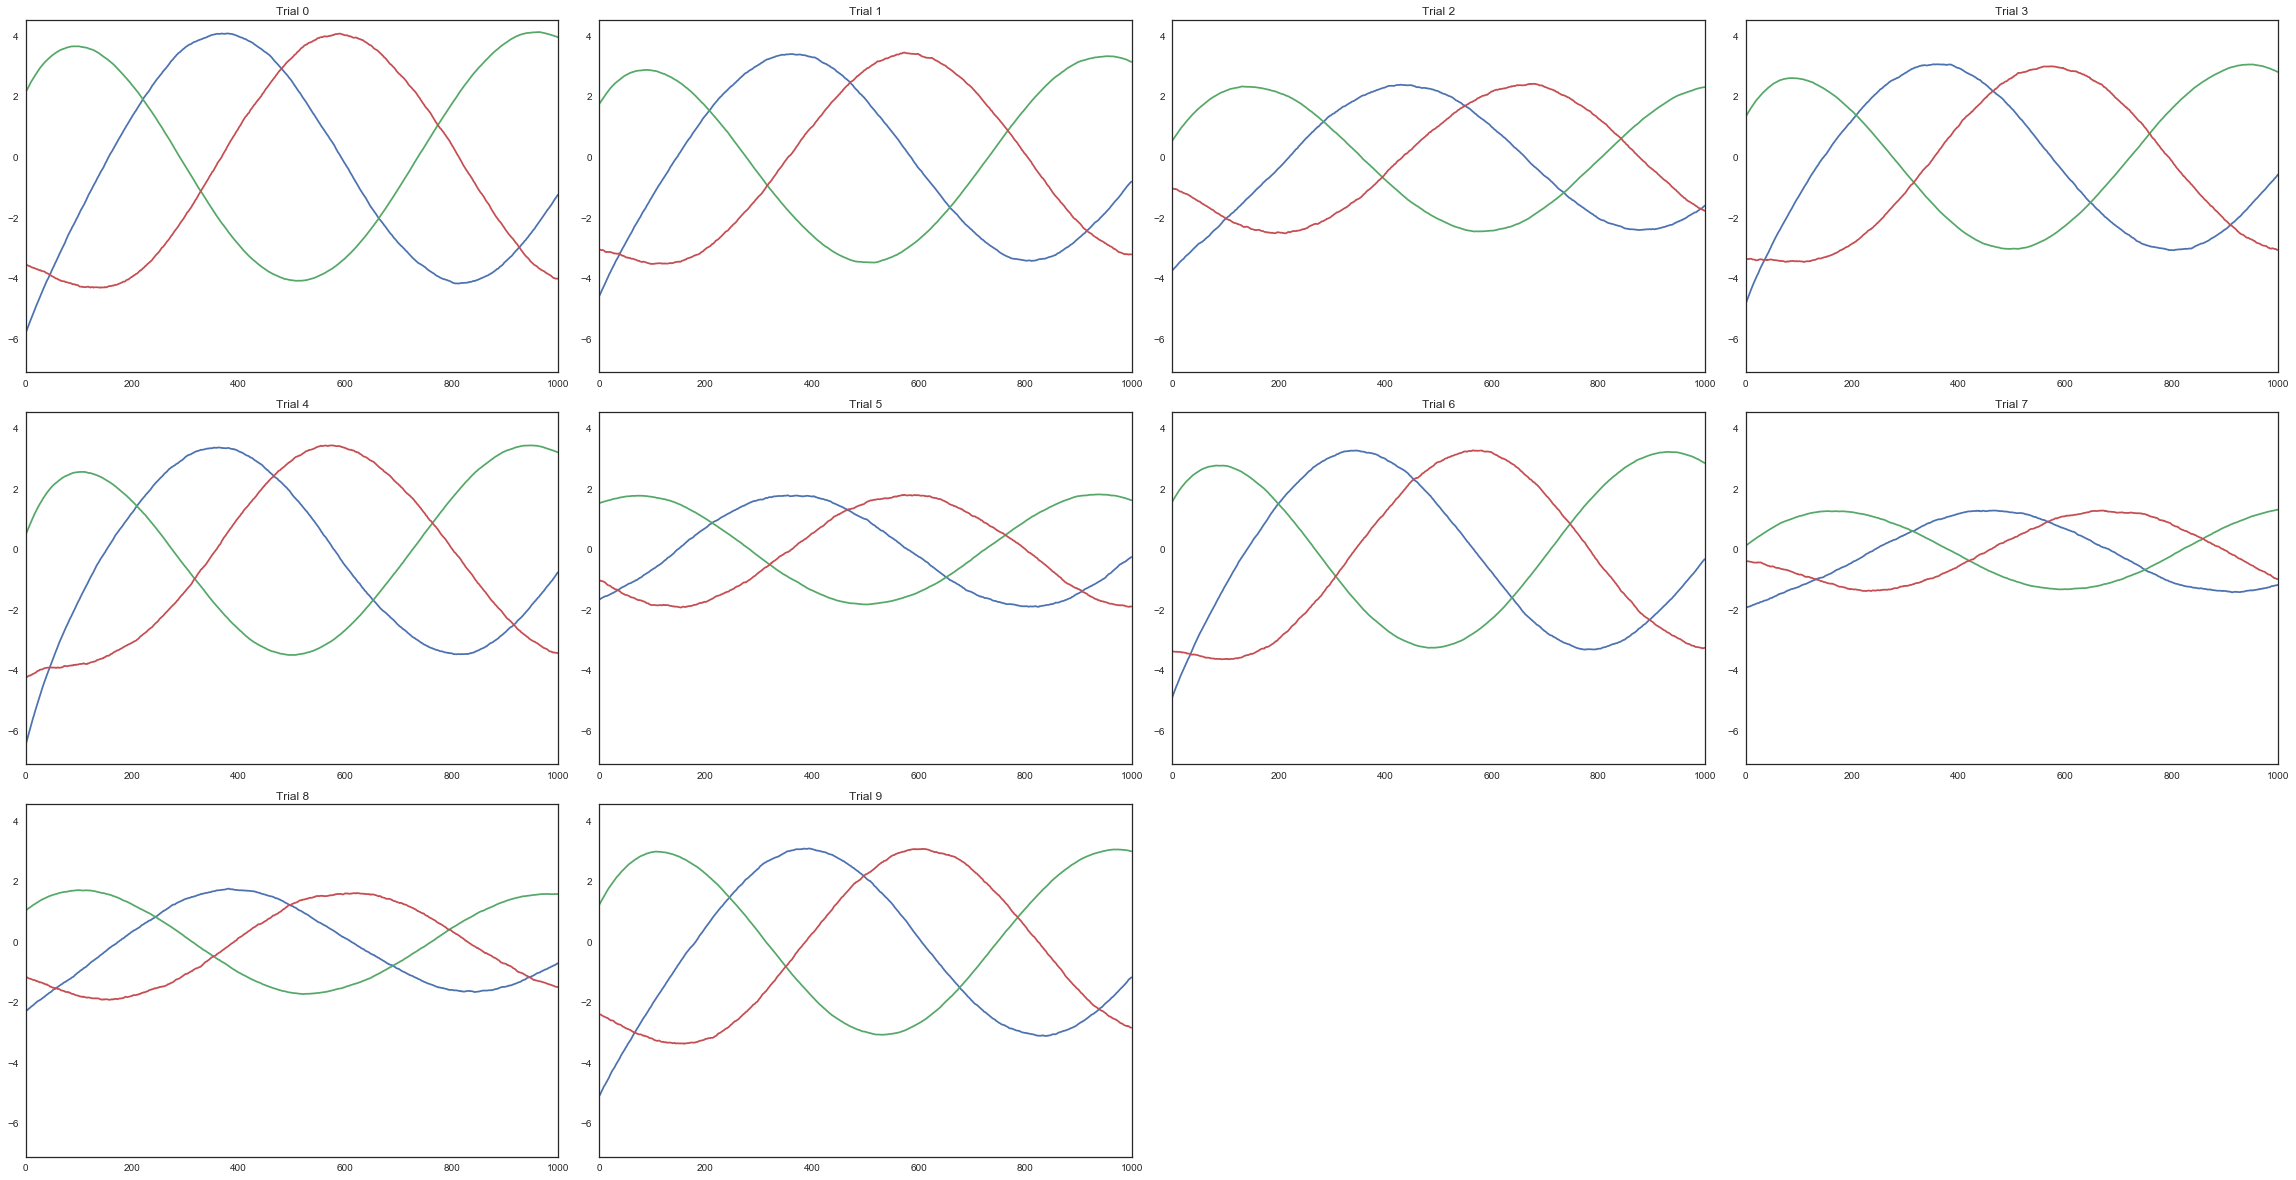

In [122]:
plt.plot(rad2deg(best_PLDS_GPFA['latentAngle']));
bestmu = best_PLDS_GPFA['mu']
bestx = PLDSSample[idx]['x']
rotated = np.empty_like(bestmu)

for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestmu[i, :]), bestx[i, :])

graph.dynplot(rotated)
graph.dynplot(bestx)

In [103]:
best_PLDS_GPFA.keys()

dict_keys(['LLtrain', 'loadingAngle', 'latentAngle', '__globals__', '__version__', 'seqTrain', 'iterTime', '__header__'])

In [104]:
fvLGP = [os.path.join(outputpath, 'PLDS_{}_PLDS'.format(i+1)) for i in range(nsample) ]
PLDS_PLDS = [loadmat(fname, squeeze_me=True) for fname in fvLGP]

In [105]:
idx = np.array([r['latentAngle'][-1] for r in PLDS_PLDS]).argmin()
best_PLDS_PLDS = PLDS_PLDS[idx]
print('Best: ', idx)

Best:  0


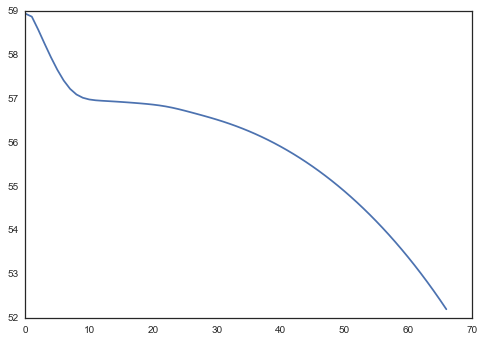

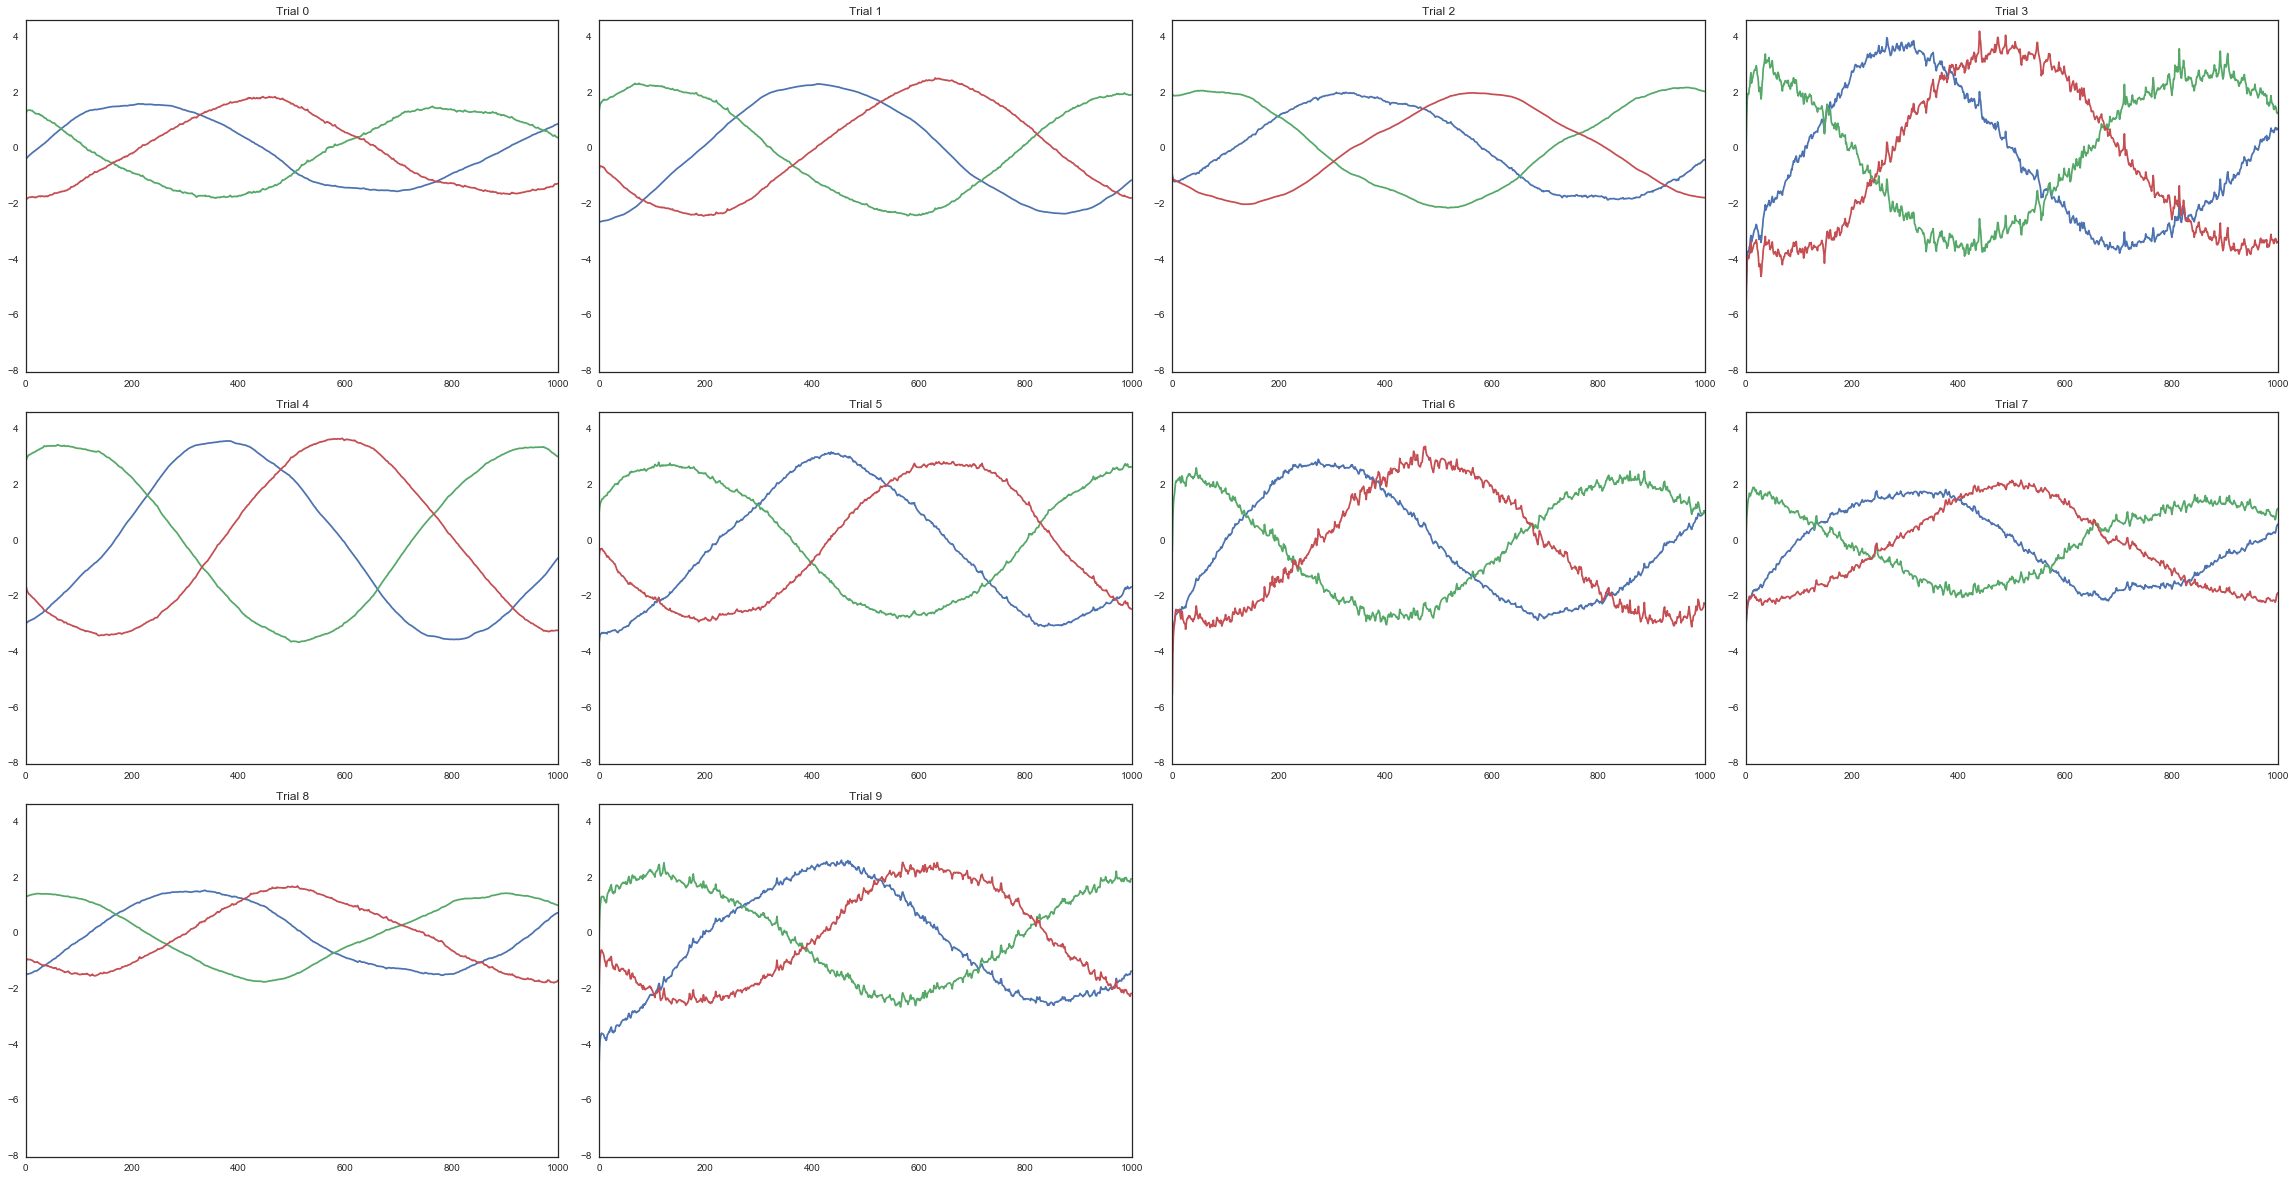

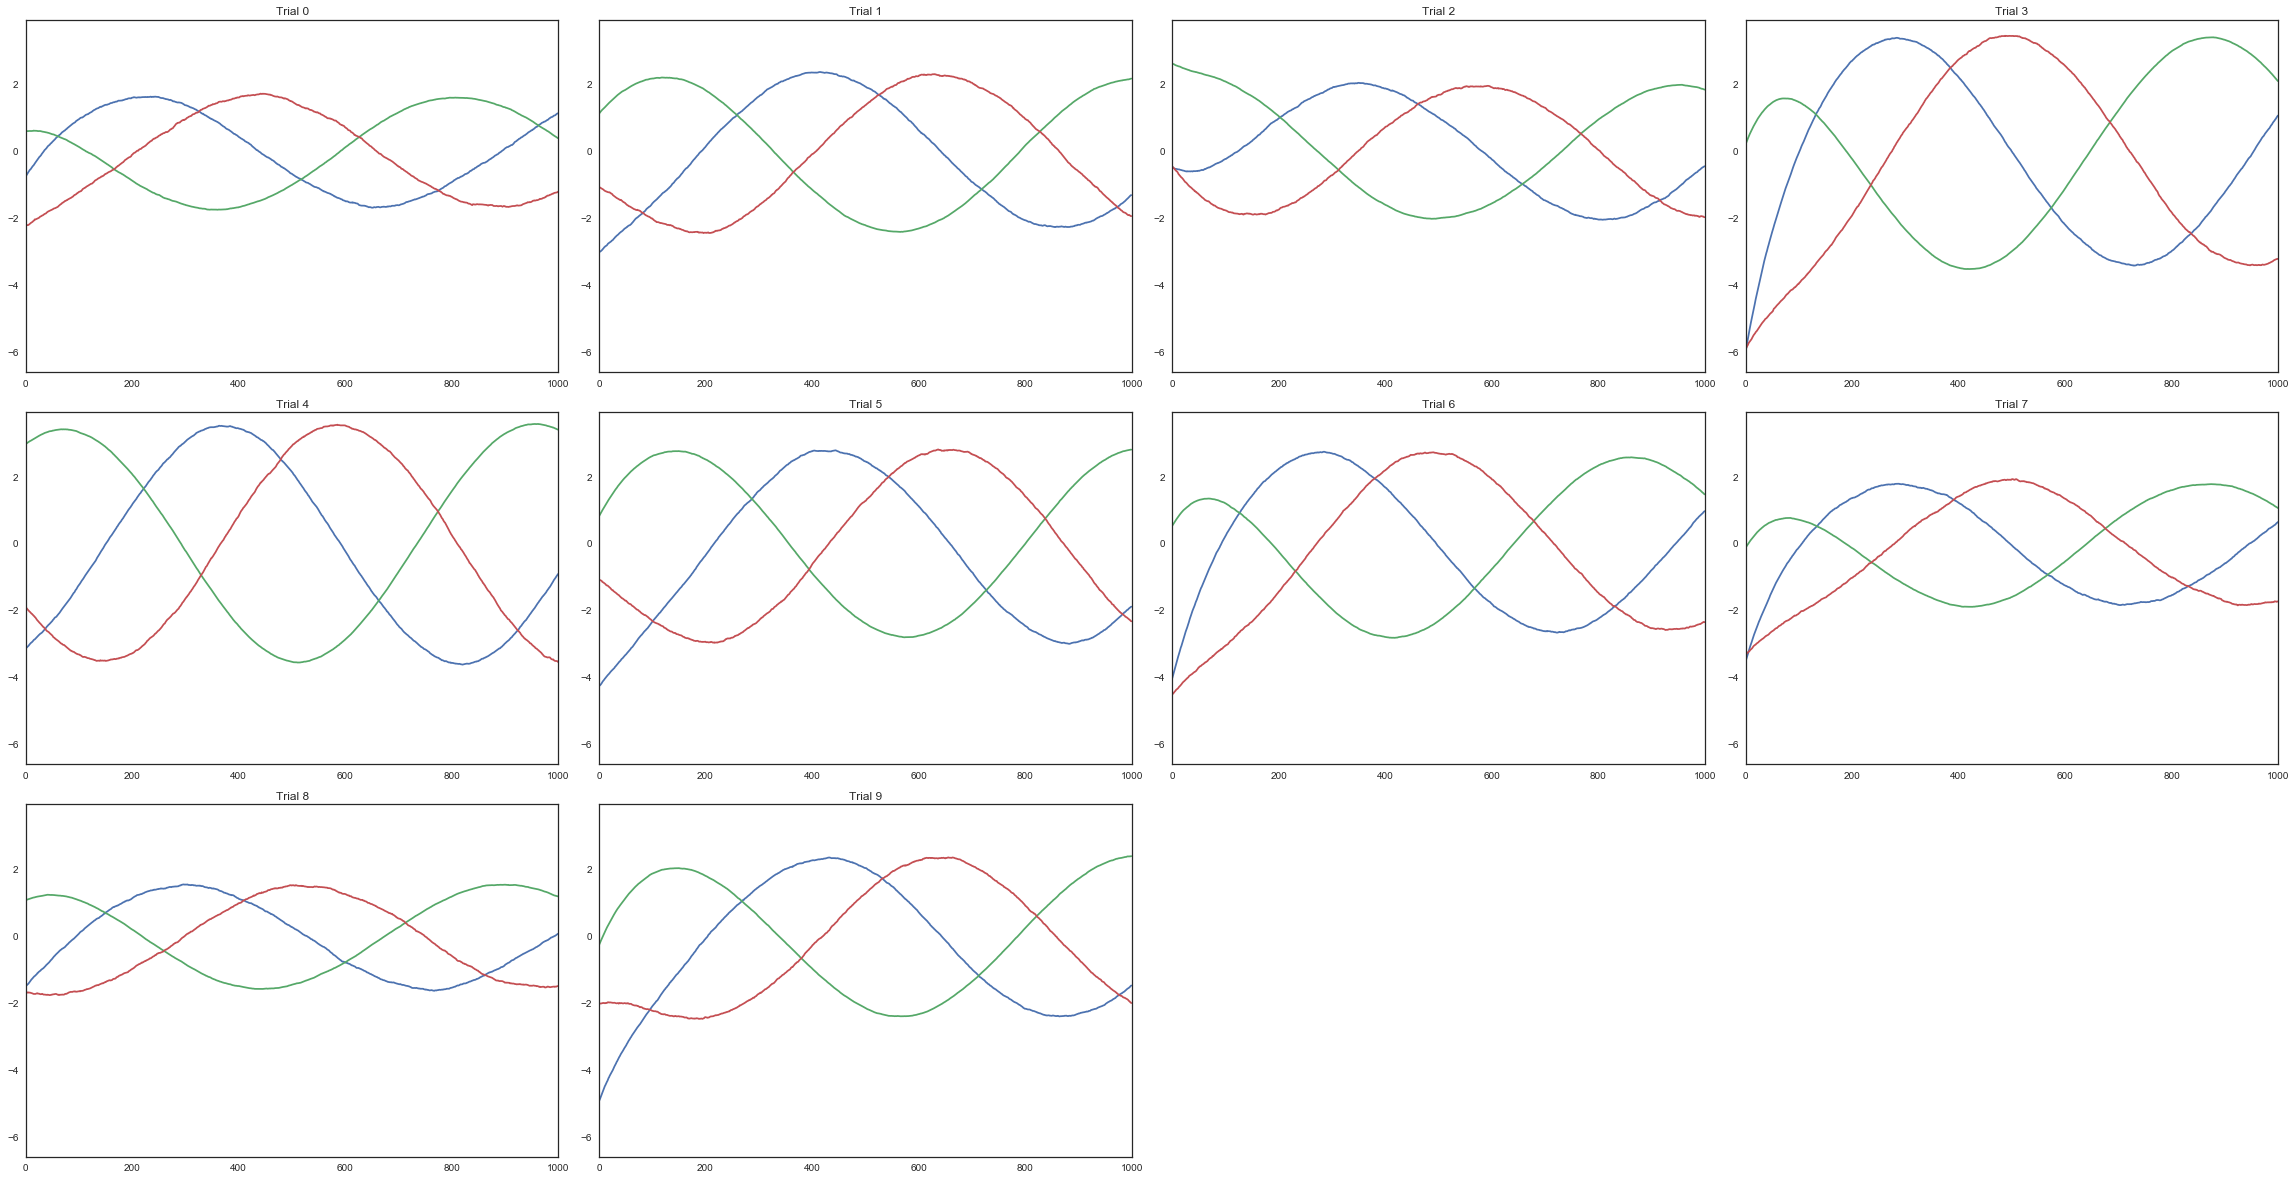

In [115]:
plt.plot(rad2deg(best_PLDS_PLDS['latentAngle']));
bestmu = np.rollaxis(best_PLDS_PLDS['xsm'], axis=-1).transpose((0, 2, 1))
bestx = np.rollaxis(np.dstack(best_PLDS_PLDS['seq']['x']), axis=-1).transpose((0, 2, 1))
rotated = np.empty_like(bestmu)

for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestmu[i, :]), bestx[i, :])

graph.dynplot(rotated)
graph.dynplot(bestx)

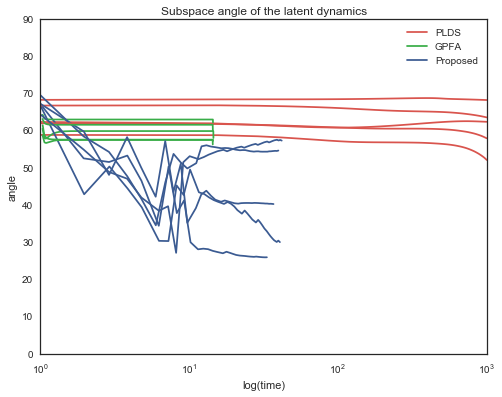

In [125]:
plt.figure(figsize=(8, 6));
for i in range(nsample):
    PLDS_PLDS[i]['Time'][0] = 1
    PLDS_GPFA[i]['iterTime'][0] = 1
    PLDS_vLGP[i]['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(PLDS_PLDS[i]['Time']), rad2deg(PLDS_PLDS[i]['latentAngle']), color=PLDScolor);
    plt.semilogx(np.cumsum(PLDS_GPFA[i]['iterTime']), rad2deg(PLDS_GPFA[i]['latentAngle']), color=GPFAcolor);
    plt.semilogx(np.cumsum(PLDS_vLGP[i]['Elapsed'][:,2]), rad2deg(PLDS_vLGP[i]['LatentAngle']), color=vLGPcolor);
plt.xlabel('log(time)');
plt.ylabel('angle');
plt.title('Subspace angle of the latent dynamics');
plt.ylim([0, 90]);
PLDSline = Line2D((0, 0), (1, 1), color=PLDScolor);
GPFAline = Line2D((0, 0), (1, 1), color=GPFAcolor);
vLGPline = Line2D((0, 0), (1, 1), color=vLGPcolor);
plt.legend(handles=[PLDSline, GPFAline, vLGPline], labels=['PLDS', 'GPFA', 'Proposed']);
plt.savefig(os.path.join(outputpath, 'latent_angle_of_plds.pdf'))

In [129]:
PLDSCV_vLGP = [loadmat('{}/PLDS_{}_vLGP_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
PLDSCV_PLDS = [loadmat('{}/PLDS_{}_PLDS_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
PLDSCV_GPFA = [loadmat('{}/PLDS_{}_GPFA_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


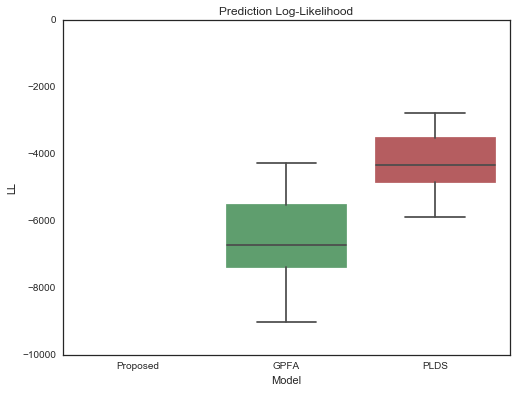

In [130]:
LL = np.zeros((nsample, ntrial, 3))

for i in range(5):
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_vLGP[i]['yhat']), axis=(1, 2))
    LL[i, :, 1] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_GPFA[i]['yhat']**2), axis=(1, 2))
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_PLDS[i]['yhat']), axis=(1, 2))
plt.figure(figsize=(8, 6));
ax = sns.boxplot(data=pd.DataFrame(LL.reshape((-1, 3)), columns=['Proposed', 'GPFA', 'PLDS']), showfliers=False);
plt.xlabel('Model');
plt.ylabel('LL')
plt.title('Prediction Log-Likelihood');
plt.savefig(os.path.join(outputpath, 'prediction_LL_plds.pdf'))
